In [502]:
import numpy as np
import scipy.signal
import torch
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter
import torchaudio
import itertools
import tqdm
import torch.nn.functional as F
import scipy as sp
import torch.nn as nn
import fb
import pickle

In [503]:
HYPERPARAMS = {
    "synth": {
        "N": 1032,
        "J": 58,
        "T": 32,
        "sr": 16000,
        "fmin": 64,
        "fmax": 8000,
        "batch_size": 32
    },
}

spec = HYPERPARAMS["synth"]

In [465]:
# load the info about the target fb as dictionaries, containing:
#   "freqz" frequency responses as 2D array (time,channels)
#   "centerfreq" 
#   "bandwidths"
#   "framebounds" computed without subsampling
with open('Target Filterbanks/CQT/CQT.pkl', 'rb') as fp:
    CQT = pickle.load(fp)

CQT_freq = CQT["freqz"]
CQT_torch = torch.from_numpy(CQT_freq.T)

In [466]:
w_init = np.load('w_init.npy')
w_tight = np.load('w_tight_fir.npy')
w_init = torch.from_numpy(w_init)
w_tight = torch.from_numpy(w_tight)
#w_init, w_tight = fb.random_filterbank(spec["N"], spec["J"], spec["T"], tight=True, to_torch=True, support_only=True)

In [471]:
synth = fb.generate_random_sine(
    spec["sr"],
    spec["fmin"],
    spec["fmax"],
    spec["N"],
    spec["batch_size"])

In [ ]:
def filterbank_response_fft(x, w):
    # some shaping
    x = x.reshape(x.shape[0], 1, x.shape[-1])
    w = w.unsqueeze(0).float()
    Wx = torch.fft.ifft(torch.fft.fft(x, dim=-1) * w, dim=-1)
    Wx = torch.abs(Wx)
    phi = torch.ones(spec["J"], spec["J"], spec["T"])
    Ux = F.conv1d(Wx, phi, bias=None, stride=64, padding=0)
    Ux = torch.abs(Ux)
    return Ux

In [472]:
# conv1D layer with circulant boundary conditions

class TDFilterbank_real(torch.nn.Module):
    def __init__(self, spec, w_init):
        super().__init__()
        
        self.psi = torch.nn.Conv1d(
            in_channels=1,
            out_channels=spec["J"],
            kernel_size=spec["T"],
            stride=1,
            padding=0,
            bias=False)

        self.psi.weight.data = w_init[:, :spec["T"]].unsqueeze(1).float()

        # self.psi_imag = torch.nn.Conv1d(
        #     in_channels=1,
        #     out_channels=spec["J"],
        #     kernel_size=spec["T"],
        #     stride=1,
        #     padding=0,
        #     bias=False)
        
        # self.psi_imag.weight.data = w_init_imag[:, :spec["T"]].unsqueeze(1).float()

        # self.phi = torch.nn.Conv1d(
        #     in_channels=spec["J"],
        #     out_channels=spec["J"],
        #     kernel_size=spec["T"],
        #     stride=128,
        #     padding=0,
        #     groups=spec["J"],
        #     bias=False)

        # with torch.no_grad():
        #     self.phi.weight = nn.Parameter(p, requires_grad=False)
        
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[-1])
        x = F.pad(x, (0, spec["T"]-1), mode='circular',)
        Wx = torch.abs(self.psi(x))
        # Wx_imag = self.psi_imag(x)
        # Ux = (Wx_real*Wx_real + Wx_imag*Wx_imag)
        phi = torch.ones(spec["J"], spec["J"], spec["T"])
        Ux = F.conv1d(Wx, phi, bias=None, stride=64, padding=0)
        return Ux
    
baseline = TDFilterbank_real(spec, w_init)
print(baseline)

TDFilterbank_real(
  (psi): Conv1d(1, 58, kernel_size=(32,), stride=(1,), bias=False)
)


In [473]:
# check sizes
filterbank_response_fft(next(synth), CQT_torch).shape, baseline(next(synth)).shape

(torch.Size([32, 58, 16]), torch.Size([32, 58, 16]))

In [498]:
# loss functions with penalization terms

# penalizing large kappa

class KappaLoss(nn.Module):
    def __init__(self):
        super(KappaLoss, self).__init__()
        self.loss = nn.CosineSimilarity(dim=0)

    def forward(self, inputs, targets, w):
        w = torch.cat((w,torch.zeros([spec["J"], spec["N"]-spec["T"]])),dim=1)
        w_hat = torch.sum(torch.abs(torch.fft.fft(w,dim=1))**2,dim=0)
        Lam_max = torch.max(w_hat,dim=0).values
        Lam_min = torch.min(w_hat,dim=0).values
        loss = 0.5*torch.mean(1-self.loss(inputs, targets)) + 0.01*Lam_max/Lam_min
        return loss
    
# penalizing large ||S - I||^2
    
class SLoss(nn.Module):
   def __init__(self):
       super(SLoss, self).__init__()

   def forward(self, inputs, targets, w):
       w = torch.cat((w,torch.zeros([spec["J"], spec["N"]-spec["T"]])),dim=1)
       W = fb.circulant(w)
       S = torch.matmul(W.T,W)
       I = torch.eye(S.shape[0])
       loss = torch.mean(torch.abs(inputs - targets)**2) + 0.001*torch.norm(S-I)**2
       return loss
    
# penalizing large ||diag(S) - I||^2
    
class DiagSLoss(nn.Module):
    def __init__(self):
        super(DiagSLoss, self).__init__()

    def forward(self, inputs, targets, w):
        S = fb.S_diag(w)
        loss = torch.mean(torch.abs(inputs - targets)**2) + 0.01*torch.norm(S-1)**2
        return loss

In [499]:
# training function

def train(baseline, penalization, lr, n_epochs, epoch_size):
    optimizer = torch.optim.Adam(baseline.parameters(), lr=lr)
    mse = torch.nn.CosineSimilarity(dim=0)
    if penalization == 'mse':
        criterion = torch.nn.CosineSimilarity(dim=0) 
    if penalization == 'kappa':
        criterion = KappaLoss() 
    if penalization == 'S':
        criterion = SLoss() 
    if penalization == 'diagS':
        criterion = DiagSLoss() 
    losses = []
    conditions = []

    w = baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.concatenate((w,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
    A,B = fb.frame_bounds_lp(w)
    conditions.append(B/A)

    running_loss = 0.0
    for _ in range(epoch_size):
        inputs = next(synth)
        outputs = baseline(inputs)
        targets = filterbank_response_fft(inputs, CQT_torch)
        w = baseline.psi.weight[:,0,:]
        loss = 0.5*torch.mean(1-mse(outputs, targets))
        running_loss += loss.item()
    print(1000 * running_loss)
    losses.append(running_loss)

    for _ in range(n_epochs):
        running_loss = 0.0
        for i in tqdm.tqdm(range(epoch_size)):
            inputs = next(synth)
            optimizer.zero_grad()
            outputs = baseline(inputs)
            targets = filterbank_response_fft(inputs, CQT_torch)
            if penalization == 'mse':
                loss = 0.5*torch.mean(1-mse(outputs, targets))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            if penalization == 'kappa':
                w = baseline.psi.weight[:,0,:]
                loss = criterion(outputs, targets, w)
                loss.backward()
                optimizer.step()
                loss2 = 0.5*torch.mean(1-mse(outputs, targets))
                running_loss += loss2.item()
            if penalization == 'S' or penalization == 'diagS':
                # use this loss only every 10th iteration
                if np.mod(i,10) == 0:
                    w = baseline.psi.weight[:,0,:]
                    loss = criterion(outputs, targets, w)
                    loss.backward()
                    optimizer.step()
                else:
                    loss = mse(outputs, targets)
                    loss.backward()
                    optimizer.step()                
                    loss2 = mse(outputs, targets)
                    running_loss += loss2.item()
        losses.append(running_loss)
        w = baseline.psi.weight.detach().numpy()[:,0,:]
        w = np.concatenate((w,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
        A,B = fb.frame_bounds_lp(w)
        conditions.append(B/A)
        print(1000 * running_loss)

    return losses, conditions

In [500]:
n_epochs = 10
epoch_size = 50
lr = 0.0001

baseline = TDFilterbank_real(spec, w_init)
losses_mse, conditions_mse = train(
    baseline=baseline,
    penalization='mse',
    lr=lr,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

w_no = baseline.psi.weight.detach().numpy()[:,0,:]

baseline = TDFilterbank_real(spec, w_init)
losses_kappa, conditions_kappa = train(
    baseline=baseline,
    penalization='kappa',
    lr=lr,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

w_kappa = baseline.psi.weight.detach().numpy()[:,0,:]

baseline = TDFilterbank_real(spec, w_tight)
losses_tight, conditions_tight = train(
    baseline=baseline,
    penalization='kappa',
    lr=lr,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

w_tight = baseline.psi.weight.detach().numpy()[:,0,:]

1636.6686318069696


100%|██████████| 50/50 [00:04<00:00, 12.03it/s]


986.217450350523


100%|██████████| 50/50 [00:03<00:00, 14.06it/s]


702.0065495744348


100%|██████████| 50/50 [00:03<00:00, 13.76it/s]


675.477716140449


100%|██████████| 50/50 [00:03<00:00, 16.26it/s]


628.4269774332643


100%|██████████| 50/50 [00:03<00:00, 16.39it/s]


608.7189866229892


100%|██████████| 50/50 [00:03<00:00, 16.31it/s]


561.9674497283995


100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


584.8875418305397


100%|██████████| 50/50 [00:03<00:00, 14.07it/s]


559.448420535773


100%|██████████| 50/50 [00:03<00:00, 16.17it/s]


538.3804868906736


100%|██████████| 50/50 [00:03<00:00, 16.45it/s]


549.3737724609673
1696.1519662290812


100%|██████████| 50/50 [00:03<00:00, 13.38it/s]


1163.6531986296177


100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


950.562029145658


100%|██████████| 50/50 [00:03<00:00, 14.19it/s]


894.8084441944957


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


882.6233632862568


100%|██████████| 50/50 [00:03<00:00, 14.17it/s]


866.9881438836455


100%|██████████| 50/50 [00:03<00:00, 14.21it/s]


854.449076578021


100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


837.0992466807365


100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


807.4749195948243


100%|██████████| 50/50 [00:03<00:00, 14.28it/s]


804.8661202192307


100%|██████████| 50/50 [00:05<00:00,  9.71it/s]

788.8242825865746


AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

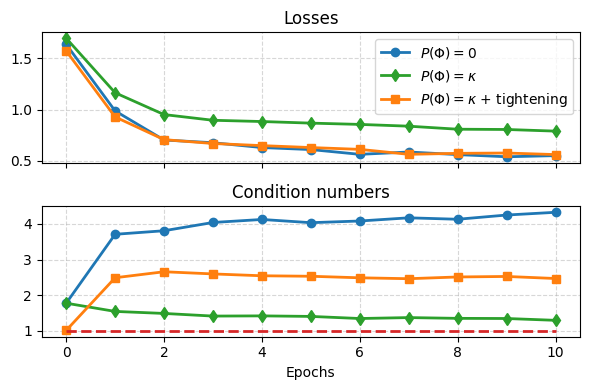

In [501]:
# plot losses and condition numbers over epochs

plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
Ts = np.arange(0, n_epochs+1)

ax = axes[0]
ax.plot(Ts, losses_mse, 'tab:blue', linewidth=2, marker = 'o', label='$P(\Phi)=0$')
ax.plot(Ts, losses_kappa, 'tab:green', linewidth=2, marker = 'd', label='$P(\Phi)=\kappa$')
ax.plot(Ts, losses_tight, 'tab:orange', linewidth=2, marker = 's', label='$P(\Phi)=\kappa$ + tightening')

ax.set_title('Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, conditions_mse, 'tab:blue', linewidth=2, marker = 'o')
ax.plot(Ts, conditions_kappa, 'tab:green', linewidth=2, marker = 'd')
ax.plot(Ts, conditions_tight, 'tab:orange', linewidth=2, marker = 's')
ax.plot(Ts, np.ones(len(Ts)), 'tab:red', linewidth=2, label='Tightened', linestyle='--')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
axes[0].legend(loc='upper right')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Fitting_Tight_Filterbanks.pdf', bbox_inches='tight')

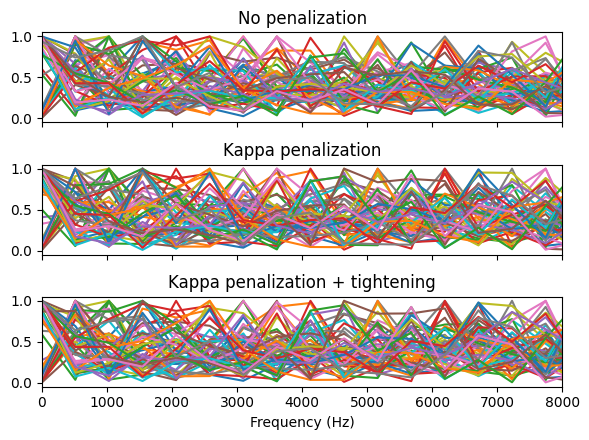

In [497]:
plt.rcParams['text.usetex'] = False

w_no_hat = np.fft.fft(w_no, axis=1).T
w_kappa_hat = np.fft.fft(w_kappa, axis=1).T
w_tight_hat = np.fft.fft(w_tight, axis=1).T

w_no_abs = np.abs(w_no_hat)/np.max(np.abs(w_no_hat), axis=0)
w_kappa_abs = np.abs(w_kappa_hat)/np.max(np.abs(w_kappa_hat), axis=0)
w_tight_abs = np.abs(w_tight_hat)/np.max(np.abs(w_tight_hat), axis=0)

fig, axes = plt.subplots(3, 1, figsize=(6, 4.5), sharex=True)

omega = np.linspace(0, spec["sr"], w_no.shape[1])

ax = axes[0]
ax.plot(omega, w_no_abs)
ax.set_title('No penalization')
ax.set_xlim(0, spec["sr"]//2+1)

ax = axes[1]
ax.plot(omega, w_kappa_abs)
ax.set_title('Kappa penalization')
ax.set_xlim(0, spec["sr"]//2+1)

ax = axes[2]
ax.plot(omega, w_tight_abs)
ax.set_title('Kappa penalization + tightening')
ax.set_xlim(0, spec["sr"]//2+1)

ax.set_xlabel('Frequency (Hz)')

plt.tight_layout()

plt.savefig('Filterbank_Responses.pdf', bbox_inches='tight')

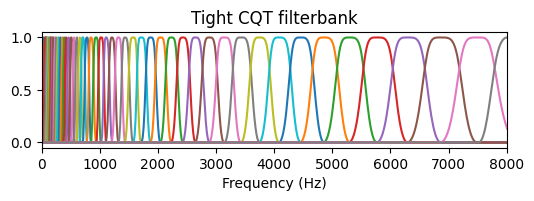

In [425]:
fig = plt.figure(figsize=(6, 1.5))

omega = np.linspace(0, spec["sr"], CQT_freq.shape[0])
plt.plot(omega, CQT_freq/ np.max(CQT_freq, axis=0));
plt.title("Tight CQT filterbank")
plt.xlim(0, spec["sr"]//2+1)
plt.xlabel("Frequency (Hz)");

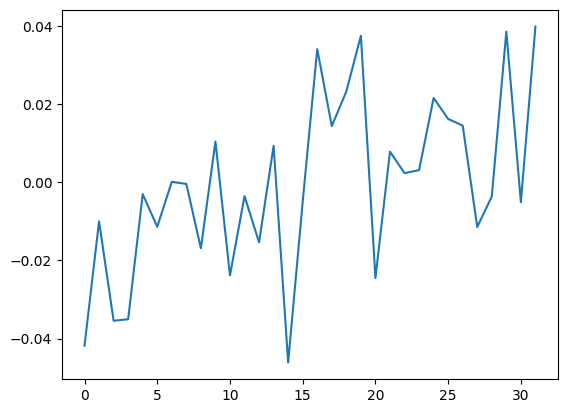

In [490]:
plt.plot(w[50,:])